Training Word2Vec model...
Generating Document Embeddings...
=== Word2Vec 评估指标 ===
Silhouette Score (Word2Vec): 0.2104
Kappa Score (Word2Vec): 0.4125


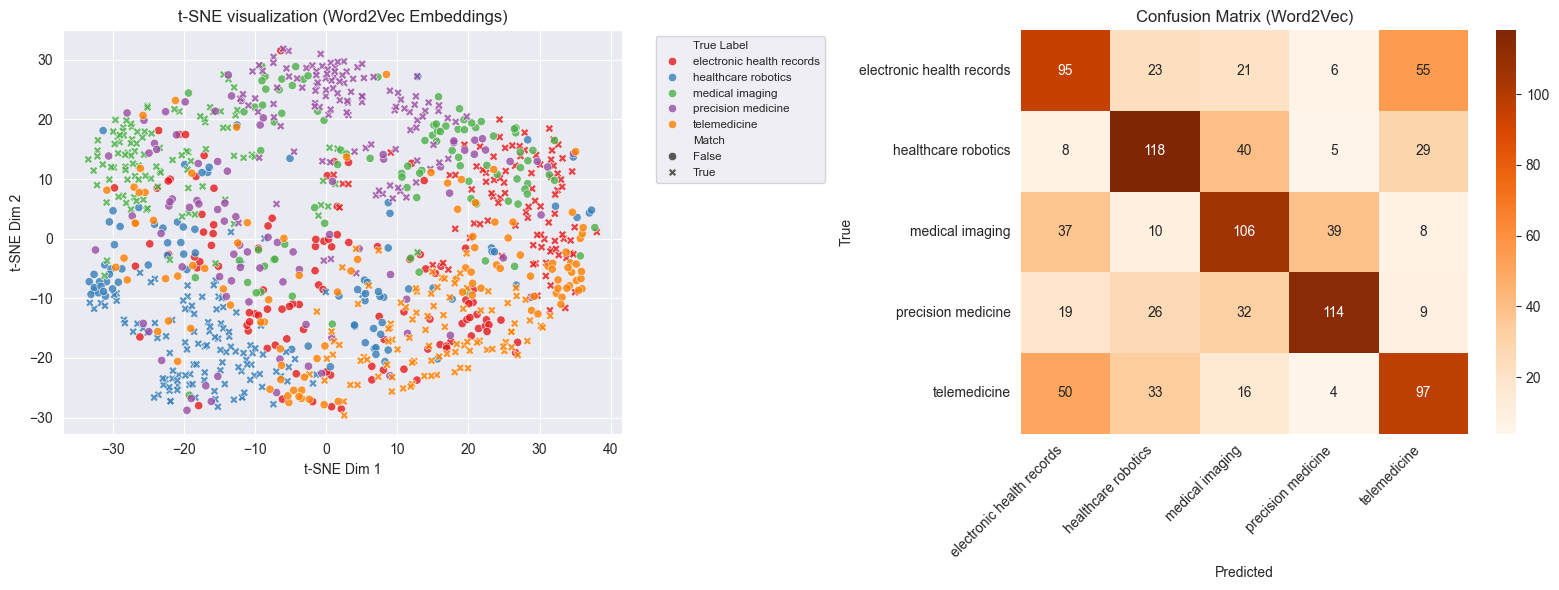

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, cohen_kappa_score, confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.manifold import TSNE

# 引入 Gensim 的 Word2Vec
from gensim.models import Word2Vec

# ----------------- 1. 数据读取与基础清理 -----------------
df = pd.read_csv('../processed_data.csv')
# 去除文本中无意义的 'pad' 填充字符
docs = df['Cleaned_Content'].fillna('').str.replace(r'\bpad\b', '', regex=True).tolist()
true_labels = df['Label'].tolist()

unique_labels = sorted(list(set(true_labels)))
label_to_id = {l: i for i, l in enumerate(unique_labels)}
y_true = [label_to_id[l] for l in true_labels]

# ----------------- 2. 训练 Word2Vec 模型 -----------------
# Tokenization: 将文档分割成词语列表
tokenized_docs = [doc.split() for doc in docs]

# 训练 Word2Vec
# vector_size=100: 词向量的维度
# window=5: 上下文窗口大小
# min_count=5: 忽略词频小于 5 的词
# workers=4: 使用 4 个 CPU 线程加速训练
print("Training Word2Vec model...")
w2v_model = Word2Vec(sentences=tokenized_docs, vector_size=100, window=5, min_count=5, workers=4, epochs=20, seed=42)

# ----------------- 3. 构建文档向量 (Document Embeddings) -----------------
def get_document_vector(doc_tokens, model):
    """
    计算文档中所有有效单词的 Word2Vec 向量的平均值
    """
    # 筛选出在模型词表中的词
    valid_words = [word for word in doc_tokens if word in model.wv.key_to_index]
    if not valid_words:
        # 如果整篇文档没有词汇在词表中，返回全零向量
        return np.zeros(model.vector_size)

    # 提取词向量并计算平均值
    word_vectors = np.array([model.wv[word] for word in valid_words])
    return word_vectors.mean(axis=0)

print("Generating Document Embeddings...")
X_w2v = np.array([get_document_vector(tokens, w2v_model) for tokens in tokenized_docs])

# ----------------- 4. K-means 聚类 -----------------
k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
y_pred_clusters = kmeans.fit_predict(X_w2v)

# 匈牙利算法匹配聚类标签与真实标签
def match_labels(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(cm, maximize=True)
    mapping = {col: row for col, row in zip(col_ind, row_ind)}
    y_pred_matched = [mapping[l] for l in y_pred]
    return np.array(y_pred_matched), mapping, cm

y_pred_matched, cluster_mapping, cm = match_labels(y_true, y_pred_clusters)

# ----------------- 5. 模型评估 -----------------
sil_score = silhouette_score(X_w2v, y_pred_clusters)
kappa = cohen_kappa_score(y_true, y_pred_matched)

print(f"=== Word2Vec 评估指标 ===")
print(f"Silhouette Score (Word2Vec): {sil_score:.4f}")
print(f"Kappa Score (Word2Vec): {kappa:.4f}")

# ----------------- 6. 结果可视化 -----------------
plt.figure(figsize=(16, 6))

# 图1: t-SNE 降维散点图 (基于 Word2Vec 稠密向量)
plt.subplot(1, 2, 1)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_w2v)
df_tsne = pd.DataFrame({
    't-SNE Dim 1': X_tsne[:,0],
    't-SNE Dim 2': X_tsne[:,1],
    'True Label': [unique_labels[i] for i in y_true],
    'Match': y_true == y_pred_matched
})
sns.scatterplot(data=df_tsne, x='t-SNE Dim 1', y='t-SNE Dim 2', hue='True Label', style='Match', palette='Set1', alpha=0.8)
plt.title('t-SNE visualization (Word2Vec Embeddings)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# 图2: 混淆矩阵
plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_true, y_pred_matched), annot=True, fmt='d', cmap='Oranges',
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix (Word2Vec)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig('clustering_eval_word2vec.png', dpi=300)
plt.show()

Training Word2Vec model...
Generating Document Embeddings...
=== Word2Vec 评估指标 ===
Silhouette Score (Word2Vec): 0.2100
Kappa Score (Word2Vec): 0.4213
NPMI Coherence (Word2Vec): 0.0537


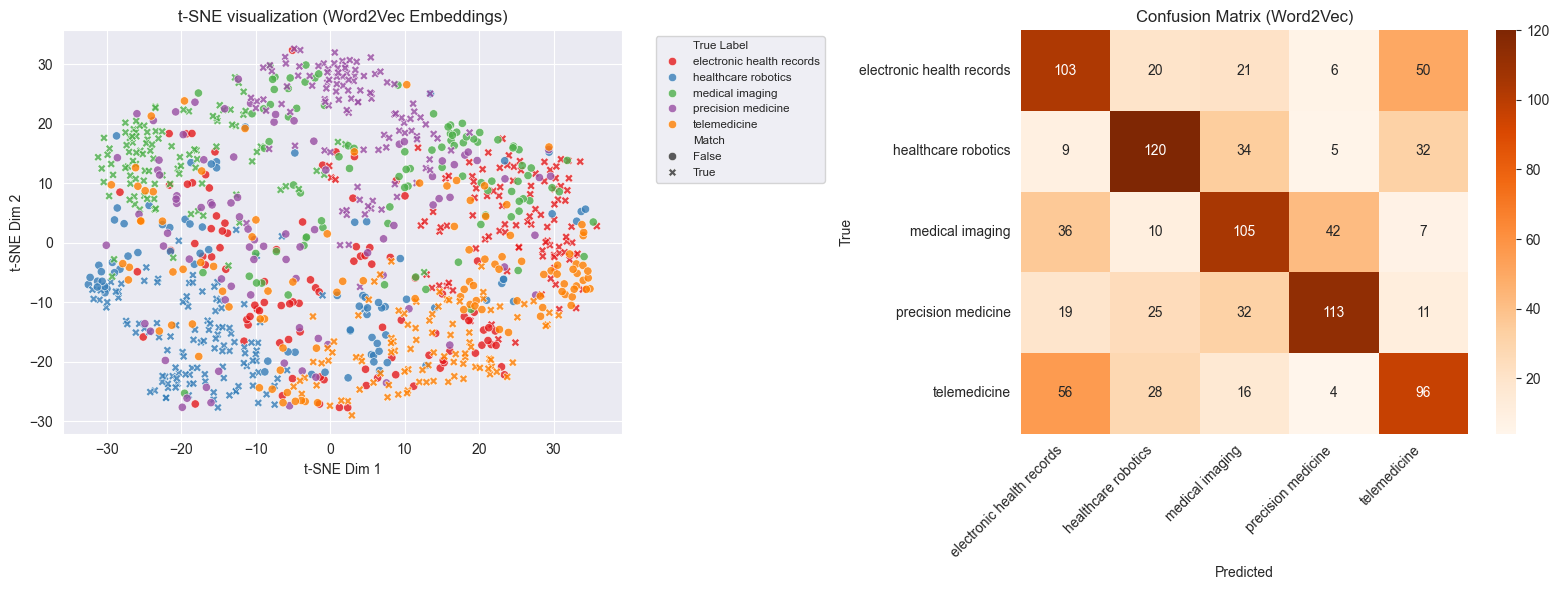

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import math
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, cohen_kappa_score, confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer

# 引入 Gensim 的 Word2Vec
from gensim.models import Word2Vec

# ----------------- 1. 数据读取与基础清理 -----------------
df = pd.read_csv('../processed_data.csv')
# 去除文本中无意义的 'pad' 填充字符
docs = df['Cleaned_Content'].fillna('').str.replace(r'\bpad\b', '', regex=True).tolist()
true_labels = df['Label'].tolist()

unique_labels = sorted(list(set(true_labels)))
label_to_id = {l: i for i, l in enumerate(unique_labels)}
y_true = [label_to_id[l] for l in true_labels]

# ----------------- 2. 训练 Word2Vec 模型 -----------------
# Tokenization: 将文档分割成词语列表
tokenized_docs = [doc.split() for doc in docs]

# 训练 Word2Vec
# vector_size=100: 词向量的维度
# window=5: 上下文窗口大小
# min_count=5: 忽略词频小于 5 的词
# workers=4: 使用 4 个 CPU 线程加速训练
print("Training Word2Vec model...")
w2v_model = Word2Vec(sentences=tokenized_docs, vector_size=100, window=5, min_count=5, workers=4, epochs=20, seed=42)

# ----------------- 3. 构建文档向量 (Document Embeddings) -----------------
def get_document_vector(doc_tokens, model):
    """
    计算文档中所有有效单词的 Word2Vec 向量的平均值
    """
    # 筛选出在模型词表中的词
    valid_words = [word for word in doc_tokens if word in model.wv.key_to_index]
    if not valid_words:
        # 如果整篇文档没有词汇在词表中，返回全零向量
        return np.zeros(model.vector_size)

    # 提取词向量并计算平均值
    word_vectors = np.array([model.wv[word] for word in valid_words])
    return word_vectors.mean(axis=0)

print("Generating Document Embeddings...")
X_w2v = np.array([get_document_vector(tokens, w2v_model) for tokens in tokenized_docs])

# ----------------- 4. K-means 聚类 -----------------
k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
y_pred_clusters = kmeans.fit_predict(X_w2v)

# 匈牙利算法匹配聚类标签与真实标签
def match_labels(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(cm, maximize=True)
    mapping = {col: row for col, row in zip(col_ind, row_ind)}
    y_pred_matched = [mapping[l] for l in y_pred]
    return np.array(y_pred_matched), mapping, cm

y_pred_matched, cluster_mapping, cm = match_labels(y_true, y_pred_clusters)

# ----------------- 5. 模型评估 (包含 NPMI Coherence) -----------------
sil_score = silhouette_score(X_w2v, y_pred_clusters)
kappa = cohen_kappa_score(y_true, y_pred_matched)

# --- 新增: 计算 NPMI Coherence ---
# 找到每个聚类中心在 Word2Vec 向量空间中最接近的 Top 10 个词作为该聚类的主题词
cluster_top_words = []
for i in range(k):
    centroid = kmeans.cluster_centers_[i]
    # 使用 similar_by_vector 找到最靠近聚类中心的词汇
    top_words_with_scores = w2v_model.wv.similar_by_vector(centroid, topn=10)
    top_words = [word for word, score in top_words_with_scores]
    cluster_top_words.append(top_words)

# 计算基于真实文档共现的 NPMI Coherence
cv_vectorizer = CountVectorizer(vocabulary=set([w for words in cluster_top_words for w in words]), binary=True)
X_binary = cv_vectorizer.fit_transform(docs).toarray()
word2id = cv_vectorizer.vocabulary_
N = len(docs)

coherence_scores = []
for top_words in cluster_top_words:
    score = 0
    pairs = list(itertools.combinations(top_words, 2))
    for w1, w2 in pairs:
        if w1 not in word2id or w2 not in word2id: continue
        id1, id2 = word2id[w1], word2id[w2]
        p_w1 = X_binary[:, id1].sum() / N
        p_w2 = X_binary[:, id2].sum() / N
        p_w12 = (X_binary[:, id1] * X_binary[:, id2]).sum() / N
        if p_w12 > 0:
            pmi = math.log(p_w12 / (p_w1 * p_w2))
            npmi = pmi / -math.log(p_w12)
            score += npmi
    coherence_scores.append(score / len(pairs) if pairs else 0)

avg_coherence = np.mean(coherence_scores)
# -----------------------------------

print(f"=== Word2Vec 评估指标 ===")
print(f"Silhouette Score (Word2Vec): {sil_score:.4f}")
print(f"Kappa Score (Word2Vec): {kappa:.4f}")
print(f"NPMI Coherence (Word2Vec): {avg_coherence:.4f}")

# ----------------- 6. 结果可视化 -----------------
plt.figure(figsize=(16, 6))

# 图1: t-SNE 降维散点图 (基于 Word2Vec 稠密向量)
plt.subplot(1, 2, 1)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_w2v)
df_tsne = pd.DataFrame({
    't-SNE Dim 1': X_tsne[:,0],
    't-SNE Dim 2': X_tsne[:,1],
    'True Label': [unique_labels[i] for i in y_true],
    'Match': y_true == y_pred_matched
})
sns.scatterplot(data=df_tsne, x='t-SNE Dim 1', y='t-SNE Dim 2', hue='True Label', style='Match', palette='Set1', alpha=0.8)
plt.title('t-SNE visualization (Word2Vec Embeddings)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# 图2: 混淆矩阵
plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_true, y_pred_matched), annot=True, fmt='d', cmap='Oranges',
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix (Word2Vec)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig('clustering_eval_word2vec.png', dpi=300)
plt.show()